#DETECCIÓN DE GRITOS MODELO CNN - ENTRENAMIENTO

###Instalación de librerias

In [ ]:
!pip install librosa

In [ ]:
# instala el compresor
!apt-get install rar

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  rar
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 295 kB of archives.
After this operation, 799 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/multiverse amd64 rar amd64 2:5.5.0-1 [295 kB]
Fetched 295 kB in 1s (407 kB/s)
Selecting previously unselected package rar.
(Reading database ... 144465 files and directories currently installed.)
Preparing to unpack .../rar_2%3a5.5.0-1_amd64.deb ...
Unpacking rar (2:5.5.0-1) ...
Setting up rar (2:5.5.0-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


###Descarga de Audios de UrbanSound8k y Gritos(Mezcla)

Los audios de gritos fueron generados por la mezcla de audios de UrbanSound8k y audios de gritos

In [ ]:
# Descarga el dataset Urban8K (no gritos)
!wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz -O urban8k.tgz

--2020-07-15 03:50:28--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘urban8k.tgz’

urban8k.tgz         100%[===================>]   5.61G  8.63MB/s    in 15m 17s 

2020-07-15 04:05:46 (6.27 MB/s) - ‘urban8k.tgz’ saved [6023741708/6023741708]



In [ ]:
# Descarga el dataset de audios con gritos
!gdown "https://drive.google.com/uc?export=download&id=10fvtPNQSeElk9dZmjfN97zG_BevoSP0h"

Downloading...
From: https://drive.google.com/uc?export=download&id=10fvtPNQSeElk9dZmjfN97zG_BevoSP0h
To: /content/out.rar
3.10GB [00:49, 62.7MB/s]


In [ ]:
# Descarga el dataset de audios de dialogos
!gdown "https://drive.google.com/uc?export=download&id=1s-JiZqbsYvBQOuEY6TxH03_7uJiXIvlY"

Downloading...
From: https://drive.google.com/uc?export=download&id=1s-JiZqbsYvBQOuEY6TxH03_7uJiXIvlY
To: /content/youtube-sounds.rar
104MB [00:01, 68.8MB/s] 


In [ ]:
# extrae los archivos de Urban8K
!tar -xzf urban8k.tgz

In [ ]:
# extrae los archivos de audios con gritos
!rar x 'out.rar'

Streaming output truncated to the last 5000 lines.
Extracting  out/fold7/512_7.wav                                           50%  OK 
Extracting  out/fold7/207_7.wav                                           50%  OK 
Extracting  out/fold7/63_7.wav                                            50%  OK 
Extracting  out/fold7/744_7.wav                                           50%  OK 
Extracting  out/fold7/116_7.wav                                           50%  OK 
Extracting  out/fold7/476_7.wav                                           50%  OK 
Extracting  out/fold7/259_7.wav                                           50%  OK 
Extracting  out/fold7/861_7.wav                                           50%  OK 
Extracting  out/fold7/275_7.wav                                           50%  OK 
Extracting  out/fold7/64_7.wav                                            50%  OK 
Extracting  out/fold7/695_7.w

In [ ]:
!rar x 'youtube-sounds.rar'


RAR 5.50   Copyright (c) 1993-2017 Alexander Roshal   11 Aug 2017
Trial version             Type 'rar -?' for help


Extracting from youtube-sounds.rar

Creating    youtube-sounds                                            OK
Creating    youtube-sounds/youtube-sounds                             OK
Extracting  youtube-sounds/youtube-sounds/youtube-duv-1.wav                0%  OK 
Extracting  youtube-sounds/youtube-sounds/youtube-duv-10.wav               0%  OK 
Extracting  youtube-sounds/youtube-sounds/youtube-duv-11.wav               1%  OK 
Extracting  youtube-sounds/youtube-sounds/youtube-duv-12.wav               1%  OK 
Extracting  youtube-sounds/youtube-sounds/youtube-duv-13.wav               1%  OK 
Extracting  youtube-sounds/youtube-sounds/youtube-duv-14.wav               2%  OK 
Extracting  youtube-sounds/youtube-sounds/youtube-duv-15.wav               2%  OK 
Extracting  youtube-sounds/youtube-sounds/youtube-duv-16

###Importación de Librerias

In [ ]:
import pandas as pd
import numpy as np
import librosa
import glob

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D,Conv2D, Flatten, Dense, MaxPool2D, Dropout, LSTM
from tensorflow.keras.utils import to_categorical
import IPython.display as ipd
from matplotlib import pyplot

###Funciones

grab_sound_features() : Se obtiene los melspectrogram, pero antes se procesa para limitar el audio.

parser() : Procesa los audios que tienen gritos y no tienen gritos, para obtener 2 clases (0:Sin grito , 1:Tiene Grito)

In [ ]:
def grab_sound_features(filename):
    sample_rate = 12000
    duration = 3

    # Cargamos el audio
    X, sample_rate = librosa.load(filename, sr=sample_rate, res_type='kaiser_fast')
    n_sample = X.shape[0]
    n_sample_fit = int(duration*sample_rate)

    # Si el audio es muy grande, limitamos la duracion del audio.
    # Si es audio es muy pequeño se completa con ceros.
    # En ambos casos ponemos un silencio de 0.5 segundos
    if n_sample < n_sample_fit:
        X = np.hstack((0.5*sample_rate, X, np.zeros(n_sample_fit - n_sample)))
    elif n_sample > n_sample_fit:
        X = np.hstack((0.5*sample_rate, X[int((n_sample-n_sample_fit)/2):int((n_sample+n_sample_fit)/2)]))
    
    return librosa.feature.melspectrogram(y=X, sr=sample_rate).transpose()

def parser():
    feature = []
    label = []
    # Funcion para cargar archivos y extraer caracteristicas
    #for filename in glob.glob("data/scream/*.wav"):
    for filename in glob.glob("out/**/*.wav"):
        mels = grab_sound_features(filename)
        feature.append(mels)
        label.append(1)
    #for filename in glob.glob("data/no-scream/*.wav"):
    for filename in glob.glob("UrbanSound8K/audio/**/*.wav"):
        mels = grab_sound_features(filename)
        feature.append(mels)
        label.append(0)
    return [feature, label]

####Se obtiene la data

In [ ]:
data = np.array(parser())
n = data.shape[1]

In [ ]:
#Se guarda los datos obtenidos para un uso futuro
from numpy import savez_compressed
savez_compressed('audio_scream_data',data)

In [ ]:
data.shape

(2, 19032)

In [ ]:
data.shape

(2, 1873)

In [ ]:
X_ = data[0, :]
Y = data[1, :]
print(X_.shape, Y.shape)
X = np.empty([n, data[0,0].shape[0], data[0,0].shape[1]])

(19032,) (19032,)


In [ ]:
X_[20].shape

(71, 128)

In [ ]:
for i in range(n):
    X[i] = (X_[i])

In [ ]:
data[0,0].shape[1]

128

In [ ]:
Y = np.tile(Y,(data[0,0].shape[0],1)).transpose()

In [ ]:
Y = to_categorical(Y)

In [ ]:
print(X.shape)
print(Y.shape)

(19032, 71, 128)
(19032, 71, 2)


####Se divide los datos de entrenamiento y validación

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 1)

In [ ]:
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(14274, 71, 128) (4758, 71, 128) (14274, 71, 2) (4758, 71, 2)


In [ ]:
# se ajusta el tamaño de los sets
#X_train = X_train.reshape(375, 71, 128, 1)
#X_test = X_test.reshape(125, 71, 128, 1)

In [ ]:
(X_train.shape[1], X_train.shape[2])

(71, 128)

In [ ]:
input_dim = (X_train.shape[1], X_train.shape[2])

In [ ]:
input_dim

(71, 128)

### Modelo CNN (Conv1D)

In [ ]:
# Crea el modelo en tensorflow keras 
model = Sequential()

model.add(Conv1D(128,kernel_size=3,strides=1, padding="same",activation="tanh",input_shape=input_dim))
model.add(Conv1D(64,kernel_size=3,strides=1, padding="same",activation="tanh"))
model.add(Conv1D(32,kernel_size=3,strides=1, padding="same",activation="tanh"))
model.add(Dropout(0.1))
model.add(Dense(units=2, activation="softmax"))

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 71, 128)           49280     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 71, 64)            24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 71, 32)            6176      
_________________________________________________________________
dropout (Dropout)            (None, 71, 32)            0         
_________________________________________________________________
dense (Dense)                (None, 71, 2)             66        
Total params: 80,162
Trainable params: 80,162
Non-trainable params: 0
_________________________________________________________________


####Entrenamiento

In [ ]:
# se entrena el modelo en 50 epocas
history = model.fit(X_train, Y_train, epochs = 20, validation_data = (X_test, Y_test))

Epoch 1/20
447/447 [==============================] - 5s 11ms/step - loss: 0.5302 - accuracy: 0.7309 - val_loss: 0.4229 - val_accuracy: 0.8059
Epoch 2/20
447/447 [==============================] - 4s 9ms/step - loss: 0.3834 - accuracy: 0.8284 - val_loss: 0.3508 - val_accuracy: 0.8503
Epoch 3/20
447/447 [==============================] - 4s 9ms/step - loss: 0.3282 - accuracy: 0.8583 - val_loss: 0.3150 - val_accuracy: 0.8662
Epoch 4/20
447/447 [==============================] - 4s 9ms/step - loss: 0.2904 - accuracy: 0.8793 - val_loss: 0.2824 - val_accuracy: 0.8865
Epoch 5/20
447/447 [==============================] - 4s 9ms/step - loss: 0.2563 - accuracy: 0.8962 - val_loss: 0.2539 - val_accuracy: 0.8966
Epoch 6/20
447/447 [==============================] - 4s 9ms/step - loss: 0.2346 - accuracy: 0.9068 - val_loss: 0.2581 - val_accuracy: 0.8987
Epoch 7/20
447/447 [==============================] - 4s 10ms/step - loss: 0.2222 - accuracy: 0.9127 - val_loss: 0.2269 - val_accuracy: 0.9106
Epoc

In [ ]:
# se muestra el accuracy final obtenido
predictions = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print(score)

149/149 [==============================] - 1s 5ms/step - loss: 0.1567 - accuracy: 0.9432
[0.15671242773532867, 0.9432327747344971]


###Se visualiza la Precisión y Perdida

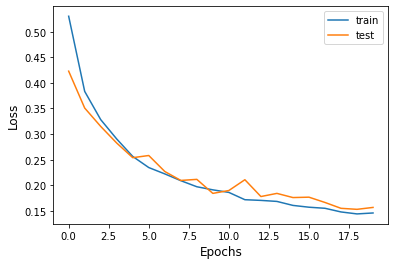

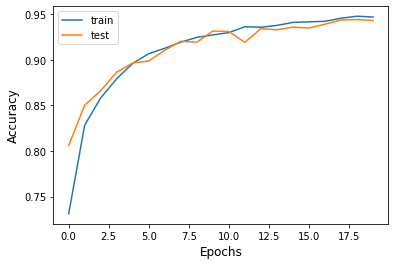

In [ ]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.xlabel('Epochs', fontsize = 12)
pyplot.ylabel('Loss', fontsize = 12)
pyplot.show()
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.xlabel('Epochs', fontsize = 12)
pyplot.ylabel('Accuracy', fontsize = 12)
pyplot.show()

In [ ]:
# Guardar el Modelo
model.save('scream_cnn.h5')